# SimFin Tutorial 04 - Signals

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"You can't go out into space with fractions. What are you going to land on? One-quarter? Three-eights? What are you going to do, when you're going from here to Venus or something?" &ndash; [Apocalypse Now](https://youtu.be/h5JXrP8yv8o?t=49)

## Introduction

It is very common in finance to calculate various kinds of signals from the raw financial data. This tutorial shows how to do such calculations and then demonstrates the built-in functions from the simfin package for calculating the most common signals. We consider several different types of signals:

- **Price signals** are calculated solely from the share-prices and trading volume, e.g. Moving Averages, MACD, etc.

- **Trigger signals** are Buy / Sell / Hold signals calculated from two price-signals crossing each other, e.g. Moving Averages of different length.

- **Financial signals** are calculated from data in financial reports such as Income Statements and Balance Sheets, e.g. Net Profit Margin, Debt Ratio, and Return on Assets (ROA).

- **Growth signals** are also calculated from the data in financial reports such as Income Statements, e.g. Sales Growth and Earnings Growth.

- **Valuation signals** are calculated from both the share-prices and data in the financial reports such as Income Statements and Balance Sheets, e.g. P/E and P/Sales ratios.

The implementation details are different for these signal types and this tutorial explains best-practices for calculating them correctly. It is assumed you are already familiar with the previous tutorials on the basics of SimFin.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.3.0'

## Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Load Datasets

In these examples, we will use the following datasets:

In [6]:
%%time
# Data for USA.
market = 'us'

# TTM Income Statements.
df_income_ttm = sf.load_income(variant='ttm', market=market)

# Quarterly Income Statements.
df_income_qrt = sf.load_income(variant='quarterly', market=market)

# TTM Balance Sheets.
df_balance_ttm = sf.load_balance(variant='ttm', market=market)

# TTM Cash-Flow Statements.
df_cashflow_ttm = sf.load_cashflow(variant='ttm', market=market)

# Quarterly Cash-Flow Statements.
df_cashflow_qrt = sf.load_cashflow(variant='quarterly', market=market)

# Daily Share-Prices.
df_prices = sf.load_shareprices(variant='daily', market=market)

Dataset "us-income-ttm" on disk (5 days old), loading.
Dataset "us-income-quarterly" on disk (5 days old), loading.
Dataset "us-balance-ttm" on disk (9 days old), loading.
Dataset "us-cashflow-ttm" on disk (5 days old), loading.
Dataset "us-cashflow-quarterly" on disk (1 days old), loading.
Dataset "us-shareprices-daily" on disk (9 days old), loading.
CPU times: user 15.9 s, sys: 1.27 s, total: 17.2 s
Wall time: 15.7 s


Select a subset of the tickers and data-columns we are interested in:

In [7]:
tickers = ['AAPL', 'AMZN', 'MSFT']

df_income_qrt = df_income_qrt.loc[tickers].copy()
df_income_ttm = df_income_ttm.loc[tickers].copy()
df_balance_ttm = df_balance_ttm.loc[tickers].copy()
df_cashflow_ttm = df_cashflow_ttm.loc[tickers].copy()
df_cashflow_qrt = df_cashflow_qrt.loc[tickers].copy()
df_prices = df_prices.loc[tickers].copy()

In [8]:
df_income_ttm.head()

SimFinId Currency  Fiscal Year Fiscal Period Publish Date  \
Ticker Report Date                                                              
AAPL   2010-03-31     111052      USD         2010            Q2   2010-04-21   
       2010-06-30     111052      USD         2010            Q3   2010-07-21   
       2010-09-30     111052      USD         2010            Q4   2010-10-27   
       2010-12-31     111052      USD         2011            Q1   2011-01-19   
       2011-03-31     111052      USD         2011            Q2   2011-04-21   

                    Shares (Basic)  Shares (Diluted)       Revenue  \
Ticker Report Date                                                   
AAPL   2010-03-31     6.304956e+09      6.415840e+09  5.112300e+10   
       2010-06-30     6.337305e+09      6.447691e+09  5.708900e+10   
       2010-09-30     6.366227e+09      6.472984e+09  6.522500e+10   
       2010-12-31     6.393793e+09      6.496383e+09  7.628300e+10   
       2011-03-31     6.421177e+09      6.519249e+09  8.745100e+10   

                    Cost of Revenue  Gross Profit  ...  \
Ticker Report Date                                 ...   
AAPL   2010-03-31     -2.999900e+10  2.112400e+10  ...   
       2010-06-30     -3.381200e+10  2.327700e+10  ...   
       2010-09-30     -3.954100e+10  2.568400e+10  ...   
       2010-12-31     -4.671200e+10  2.957100e+10  ...   
       2011-03-31     -5.328700e+10  3.416400e+10  ...   

                    Non-Operating Income (Loss)  Interest Expense, Net  \
Ticker Report Date                                                       
AAPL   2010-03-31                   188000000.0                    NaN   
       2010-06-30                   186000000.0                    NaN   
       2010-09-30                   155000000.0                    NaN   
       2010-12-31                   258000000.0                    NaN   
       2011-03-31                   234000000.0                    NaN   

                    Pretax Income (Loss), Adj.  Abnormal Gains (Losses)  \
Ticker Report Date                                                        
AAPL   2010-03-31                  15208000000                      NaN   
       2010-06-30                  16808000000                      NaN   
       2010-09-30                  18540000000                      NaN   
       2010-12-31                  21745000000                      NaN   
       2011-03-31                  25616000000                      NaN   

                    Pretax Income (Loss)  Income Tax (Expense) Benefit, Net  \
Ticker Report Date                                                            
AAPL   2010-03-31            15208000000                      -4.396000e+09   
       2010-06-30            16808000000                      -4.571000e+09   
       2010-09-30            18540000000                      -4.527000e+09   
       2010-12-31            21745000000                      -5.106000e+09   
       2011-03-31            25616000000                      -6.064000e+09   

                    Income (Loss) from Continuing Operations  \
Ticker Report Date                                             
AAPL   2010-03-31                                10812000000   
       2010-06-30                                12237000000   
       2010-09-30                                14013000000   
       2010-12-31                                16639000000   
       2011-03-31                                19552000000   

                    Net Extraordinary Gains (Losses)   Net Income  \
Ticker Report Date                                                  
AAPL   2010-03-31                                NaN  10812000000   
       2010-06-30                                NaN  12237000000   
       2010-09-30                                NaN  14013000000   
       2010-12-31                                NaN  16639000000   
       2011-03-31                                NaN  19552000000   

                    Ne

In [9]:
df_prices.head()

SimFinId     Open      Low     High    Close  Adj. Close  \
Ticker Date                                                                   
AAPL   2007-01-03    111052  12.3278  11.7000  12.3686  11.9714       10.42   
       2007-01-04    111052  12.0071  11.9743  12.2786  12.2371       10.65   
       2007-01-05    111052  12.2529  12.0571  12.3143  12.1500       10.57   
       2007-01-08    111052  12.2800  12.1829  12.3614  12.2100       10.62   
       2007-01-09    111052  12.3500  12.1643  13.2829  13.2243       11.51   

                   Dividend     Volume  
Ticker Date                             
AAPL   2007-01-03       NaN  309579900  
       2007-01-04       NaN  211815100  
       2007-01-05       NaN  208685400  
       2007-01-08       NaN  199276700  
       2007-01-09       NaN  837324600

## GroupBy

When using data from multiple rows of a DataFrame that is indexed by Tickers, you **MUST** use the `groupby` operator to do the calculations on a per-Ticker basis!

The DataFrames that are indexed by both Tickers and Dates, will be printed nicely by Pandas with separation between the different Tickers. But this separation between Tickers is **not** respected when Pandas does operations on the DataFrames. This can result in some very strange data-errors, if you are doing calculations that use multiple rows of data, because some rows may belong to one Ticker, while other rows belong to another Ticker.

See Tutorial 01 for detailed examples of using the `groupby` operator.

## Price Signals

We will first show how to calculate signals from the raw share-prices. These are also known as [Technical Indicators](https://en.wikipedia.org/wiki/Technical_indicator).

Let us first plot the closing share-prices for the AAPL stock:

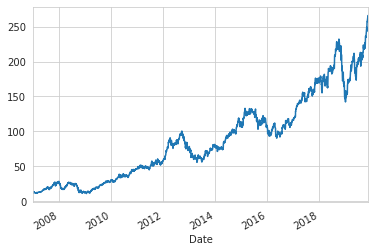

In [10]:
df_prices.loc['AAPL', CLOSE].plot()

Pandas provides a lot of functionality for calculating price-signals quite easily. For example, we may calculate the 200-day moving average like this, which basically just smoothens the raw data:

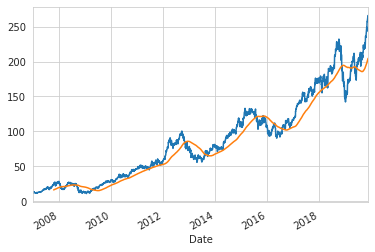

In [11]:
# Plot the raw share-prices.
df_prices.loc['AAPL', CLOSE].plot()

# Overlay plot of 200-day moving average.
df_prices.loc['AAPL', CLOSE].rolling(window=200).mean().plot()

Because these signals are calculated from multiple rows of data, we **MUST** use Pandas' `groupby` operator when calculating the signals for multiple stocks in a DataFrame.

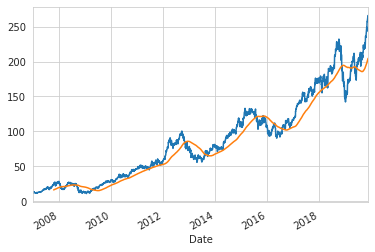

In [12]:
# Calculate moving average for all stocks in DataFrame.
df_mavg = df_prices.groupby(TICKER, group_keys=False).rolling(window=200).mean()

# Plot the raw share-prices from the original DataFrame.
df_prices.loc['AAPL', CLOSE].plot()

# Overlay plot of 200-day moving average from the new DataFrame.
df_mavg.loc['AAPL', CLOSE].plot()

If you want to calculate multiple price-signals, you can create a small helper-function. Note that this function only works for DataFrames with a single stock. We will show below how to apply this function on DataFrames with multiple stocks.

In [13]:
def price_signals(df_prices):
    """
    Calculate price-signals for a single stock.
    Use sf.apply() with this function for multiple stocks.
    
    :param df_prices:
        Pandas DataFrame with raw share-prices for a SINGLE stock.
    
    :return:
        Pandas DataFrame with price-signals.
    """
    
    # Create new DataFrame for the signals.
    df_signals = pd.DataFrame()

    # Moving Average for past 20 days.
    df_signals[MAVG_20] = df_prices[CLOSE].rolling(window=20).mean()

    # Moving Average for past 200 days.
    df_signals[MAVG_200] = df_prices[CLOSE].rolling(window=200).mean()
    
    # Buy and Sell signals generated from the two moving averages.
    df_above = df_signals[MAVG_20] >= df_signals[MAVG_200]
    df_signals[BUY] = df_above & ~df_above.shift(1, fill_value=True)
    df_signals[SELL] = ~df_above & df_above.shift(1, fill_value=False)

    # Exponential Moving Average for past 20 days.
    df_signals[EMA] = df_prices[CLOSE].ewm(span=20).mean()
    
    # Moving Average Convergence Divergence for 12 and 26 days.
    # https://en.wikipedia.org/wiki/MACD
    df_signals[MACD] = df_prices[CLOSE].ewm(span=12).mean() - df_prices[CLOSE].ewm(span=26).mean()
    
    # MACD with extra smoothing by Exp. Moving Average for 9 days.
    df_signals[MACD_EMA] = df_signals[MACD].ewm(span=9).mean()

    # The last trading volume relative to 20-day moving average.
    df_signals[REL_VOL] = np.log(df_prices[VOLUME] / df_prices[VOLUME].rolling(window=20).mean())
    
    return df_signals

We can use this function directly on a DataFrame for a single stock:

In [14]:
# Calculate all the price-signals for a SINGLE stock.
df_price_signals = price_signals(df_prices=df_prices.loc['AAPL'])
df_price_signals.dropna().head()

,MAVG 20,MAVG 200,Buy,Sell,EMA,MACD,MACD-EMA,Relative Volume
Date,,,,,,,,
2007-10-17,22.702950,16.356485,True,False,22.793061,1.118709,1.037472,0.184139
2007-10-18,22.940020,16.420556,False,False,22.982836,1.140081,1.057993,-0.136946
2007-10-19,23.127660,16.481099,False,False,23.112633,1.108733,1.068141,0.304992
2007-10-22,23.313945,16.544892,False,False,23.283677,1.116441,1.077801,0.518559
2007-10-23,23.549515,16.616814,False,False,23.598975,1.244229,1.111087,0.572964


If we have a DataFrame with data for multiple stocks, then we can use simfin's helper-function `sf.apply` to easily calculate the price-signals for multiple stocks:

In [15]:
# Calculate all the price-signals for MULTIPLE stocks.
df_price_signals = sf.apply(df=df_prices, func=price_signals)
df_price_signals.dropna()

MAVG 20    MAVG 200    Buy   Sell         EMA      MACD  \
Ticker Date                                                                     
AAPL   2007-10-17   22.702950   16.356485   True  False   22.793061  1.118709   
       2007-10-18   22.940020   16.420556  False  False   22.982836  1.140081   
       2007-10-19   23.127660   16.481099  False  False   23.112633  1.108733   
       2007-10-22   23.313945   16.544892  False  False   23.283677  1.116441   
       2007-10-23   23.549515   16.616814  False  False   23.598975  1.244229   
...                       ...         ...    ...    ...         ...       ...   
MSFT   2019-11-11  141.995500  128.983100  False  False  142.604304  1.873657   
       2019-11-12  142.270500  129.203750  False  False  143.029608  1.995035   
       2019-11-13  142.615500  129.408400  False  False  143.437265  2.086542   
       2019-11-14  143.034000  129.626550  False  False  143.877525  2.194286   
       2019-11-15  143.662000  129.862500  False  False  144.457761  2.406059   

                   MACD-EMA  Relative Volume  
Ticker Date                                   
AAPL   2007-10-17  1.037472         0.184139  
       2007-10-18  1.057993        -0.136946  
       2007-10-19  1.068141         0.304992  
       2007-10-22  1.077801         0.518559  
       2007-10-23  1.111087         0.572964  
...                     ...              ...  
MSFT   2019-11-11  1.529779        -0.486492  
       2019-11-12  1.622830        -0.223465  
       2019-11-13  1.715572        -0.312157  
       2019-11-14  1.811315        -0.154725  
       2019-11-15  1.930264        -0.046224  

[9129 rows x 8 columns]

We can then plot a few signals for the stock AAPL:

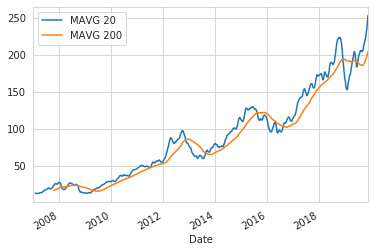

In [16]:
df_price_signals.loc['AAPL', [MAVG_20, MAVG_200]].plot()

Or we can plot a few other signals for the stock MSFT, taken from the same DataFrame:

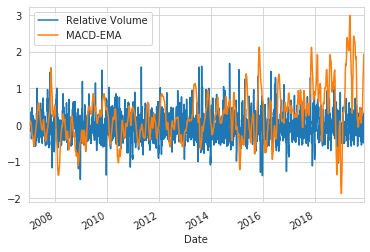

In [17]:
df_price_signals.loc['MSFT', [REL_VOL, MACD_EMA]].plot()

### Price Signals - SimFin Function

The simfin package provides a function `sf.price_signals` that calculates several basic price-signals such as Moving Averages, MACD, etc. More signals might get added in the future.

In [18]:
df_price_signals = sf.price_signals(df_prices)

In [19]:
df_price_signals.dropna().head()

EMA      MACD  MACD-EMA    MAVG 20   MAVG 200  \
Ticker Date                                                              
AAPL   2007-10-17  22.793061  1.118709  1.037472  22.702950  16.356485   
       2007-10-18  22.982836  1.140081  1.057993  22.940020  16.420556   
       2007-10-19  23.112633  1.108733  1.068141  23.127660  16.481099   
       2007-10-22  23.283677  1.116441  1.077801  23.313945  16.544892   
       2007-10-23  23.598975  1.244229  1.111087  23.549515  16.616814   

                   Relative Volume  
Ticker Date                         
AAPL   2007-10-17         0.184139  
       2007-10-18        -0.136946  
       2007-10-19         0.304992  
       2007-10-22         0.518559  
       2007-10-23         0.572964

You can add more signals to this DataFrame if you like. If your formula uses multiple rows of data at once, then you need to make a function and use `sf.apply` as shown above. But if the calculation only uses one row at a time, then it is easy to calculate and add the signal as a new data-column to the DataFrame, for example:

In [20]:
# Name for the new data-column.
REL_MAVG = 'MAVG 20 / MAVG 200'

# Calculate the signal and add as a new column to the DataFrame.
df_price_signals[REL_MAVG] = df_price_signals[MAVG_20] / df_price_signals[MAVG_200]

We can plot the new signal for ticker MSFT:

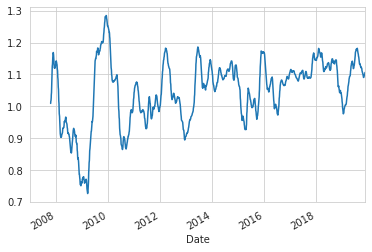

In [21]:
df_price_signals.loc['MSFT', REL_MAVG].plot()

### Trigger Signals - SimFin Function

The simfin package also provides a function for generating trigger-signals for when to Buy, Sell and Hold a stock, based on other price-signals crossing each other:

- When `signal1 >= signal2` a Hold-signal is generated.
- When `signal1` crosses above `signal2` a Buy-signal is generated.
- When `signal1` crosses below `signal2` a Sell-signal is generated.

For example, we can use the Moving Average for 20 and 200 days to generated these:

In [22]:
df_trig = sf.trig_signals(df=df_price_signals,
                          signal1=MAVG_20, signal2=MAVG_200)

We can then plot the share-prices along with the Buy and Sell-signals. First we need a helper-function for the plotting:

In [23]:
def plot_triggers(df_prices, df_trig):
    """
    Plot the closing share-price and buy/sell triggers
    for DataFrames with a single stock.
    """
    
    # Plot the closing share-price.
    ax = df_prices[CLOSE].plot()
    
    # Plot the buy-signals as vertical green dashed lines.
    for row in df_trig[df_trig[BUY]].iterrows():
        date = row[0]
        ax.axvline(x=date, linestyle='--', color='green')

    # Plot the sell-signals as verical red dotted lines.
    for row in df_trig[df_trig[SELL]].iterrows():
        date = row[0]
        ax.axvline(x=date, linestyle=':', color='red')
        
    return ax

We can then plot the share-price along with Buy and Sell triggers for ticker AAPL:

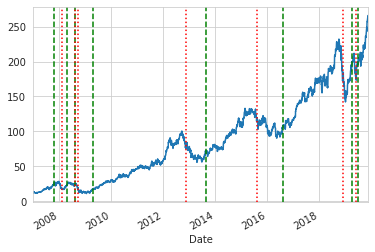

In [24]:
ticker = 'AAPL'
plot_triggers(df_prices=df_prices.loc[ticker],
              df_trig=df_trig.loc[ticker])

## Financial Signals

Let us now calculate signals from the financial reports such as Income Statements and Balance Sheets.

### Net Profit Margin

First consider the Net Profit Margin which is the fraction of the company's sales that are turned into profits for the shareholders. It is defined as:

$$
Net\ Profit\ Margin_t = \frac{Net\ Income_t}{Revenue_t}
$$

The Net Income and Revenue are found in the Income Statement of a company's financial reports. Note that the formula only uses data from a single time-step $t$, which means it only uses data for a single row in the DataFrame for the Income Statements, so we do not have to use Pandas' `groupby` functionality, and we may calculate the Net Profit Margin for multiple companies in a single DataFrame very easily:

In [25]:
df_npm = df_income_ttm[NET_INCOME] / df_income_ttm[REVENUE]
df_npm

Ticker  Report Date
AAPL    2010-03-31     0.211490
        2010-06-30     0.214350
        2010-09-30     0.214841
        2010-12-31     0.218122
        2011-03-31     0.223577
                         ...   
MSFT    2018-09-30     0.163777
        2018-12-31     0.283144
        2019-03-31     0.285784
        2019-06-30     0.311817
        2019-09-30     0.316561
Length: 117, dtype: float64

Let us plot the Net Profit Margin for ticker MSFT:

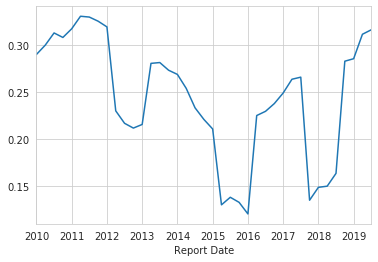

In [26]:
df_npm.loc['MSFT'].plot()

### Sales Growth

Let us now consider the quarterly year-over-year sales-growth with the formula:

$$
    Sales\ Growth_t = \frac{Revenue_t}{Revenue_{t - 1\ Year}}
$$

If we want to calculate it for a single company, then we can do it quite easily by shifting the DataFrame 4 steps, which is equivalent to 1 year because it contains quarterly data.

In [27]:
# Select the relevant data for a single ticker.
df = df_income_qrt.loc['MSFT', REVENUE]

# Calculate the growth.
df_growth = df / df.shift(4) -1

# Show the first 8 rows.
df_growth.head(8)

Report Date
2009-06-30         NaN
2009-09-30         NaN
2009-12-31         NaN
2010-03-31         NaN
2010-06-30    0.224445
2010-09-30    0.253483
2010-12-31    0.048943
2011-03-31    0.132731
Name: Revenue, dtype: float64

If we want to calculate the sales-growth for a DataFrame with multiple companies, then we **MUST** use Pandas' `groupby` functionality, because the growth-formula uses data from multiple rows.

In [28]:
# Function for calculating growth for a single company.
sales_growth = lambda df_grp: df_grp / df_grp.shift(4) - 1

# Split the DataFrame into sub-groups for the tickers,
# then apply the sales-growth function to each group,
# and finally glue the results back together.
df_growth = df_income_qrt[REVENUE].groupby(TICKER).apply(sales_growth)

# Show the result.
df_growth

Ticker  Report Date
AAPL    2009-06-30          NaN
        2009-09-30          NaN
        2009-12-31          NaN
        2010-03-31          NaN
        2010-06-30     0.612903
                         ...   
MSFT    2018-09-30     0.185264
        2018-12-31     0.122865
        2019-03-31     0.139901
        2019-06-30     0.120725
        2019-09-30     0.136536
Name: Revenue, Length: 126, dtype: float64

We can then plot the sales-growth for a single company:

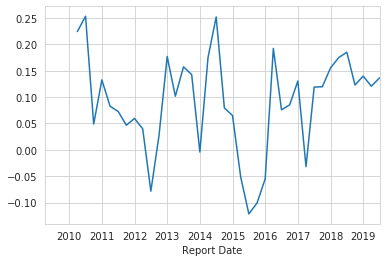

In [29]:
df_growth.loc['MSFT'].plot()

Because growth-calculations are so common, simfin provides a helper-function that works on DataFrames for one or more tickers. The function is explained in great detail in Tutorial 03. This is how we calculate 1-year sales-growth from the quarterly data:

In [30]:
# Calculate 1-year sales-growth.
df_growth = sf.rel_change(df=df_income_qrt[REVENUE], freq='q',
                          years=1, future=False)

# Show the result.
df_growth

Ticker  Report Date
AAPL    2009-06-30          NaN
        2009-09-30          NaN
        2009-12-31          NaN
        2010-03-31          NaN
        2010-06-30     0.612903
                         ...   
MSFT    2018-09-30     0.185264
        2018-12-31     0.122865
        2019-03-31     0.139901
        2019-06-30     0.120725
        2019-09-30     0.136536
Name: Revenue, Length: 126, dtype: float64

We can then plot the sales-growth for a single company:

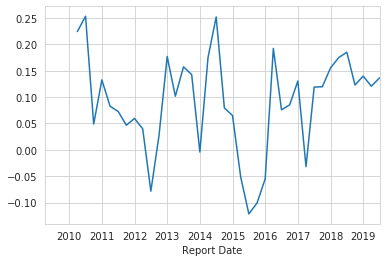

In [31]:
df_growth.loc['MSFT'].plot()

### Return on Equity

The Return on Equity (ROE) is a measure of how much profit is generated on the capital that shareholders have invested in the company through direct cash payments and retained earnings throughout the years.

There are different ways of defining and calculating ROE. The first formula is simply the Net Income for a given year $t$ divided by the Shareholder's Equity for the same year $t$.

$$
ROE_t = \frac{Net\ Income_t}{Equity_t}
$$

This formula uses data from both the Income Statement and Balance Sheet, which are found in two separate simfin datasets.

Let us calculate the ROE for a single company with ticker MSFT:

In [32]:
# Get the relevant data for a single company.
ticker = 'MSFT'
df_inc = df_income_ttm.loc[ticker]
df_bal = df_balance_ttm.loc[ticker]

# Calculate the ROE for that ticker.
df_roe = df_inc[NET_INCOME] / df_bal[TOTAL_EQUITY]

# Show the result.
df_roe.head()

Report Date
2010-03-31    0.378189
2010-06-30    0.406280
2010-09-30    0.438754
2010-12-31    0.424249
2011-03-31    0.407730
dtype: float64

We might argue that the above formula for $ROE_t$ is inaccurate because the Net Income and Equity are taken from the same period $t$. The problem is that $Net\ Income_t$ is generated in some year $t$ e.g. between January 1st and December 31st 2015, and some or all of these earnings may be retained and hence be a (possibly substantial) part of $Equity_t$ on December 31st 2015. This would distort the true return on shareholder's equity.

A simple solution is to calculate the ROE from the Net Income in a given year $t$ divided by the Equity in the previous year:

$$
ROE_t = \frac{Net\ Income_t}{Equity_{t - 1\ Year}}
$$

This can be calculated simply by shifting the time-series for the Equity 4 steps for 1 year:

In [33]:
# Calculate the ROE for a single ticker.
df_roe = df_inc[NET_INCOME] / df_bal[TOTAL_EQUITY].shift(4)

# Show the result.
df_roe.head(8)

Report Date
2010-03-31         NaN
2010-06-30         NaN
2010-09-30         NaN
2010-12-31         NaN
2011-03-31    0.476788
2011-06-30    0.501354
2011-09-30    0.500149
2011-12-31    0.484066
dtype: float64

We might also argue that the above formula for $ROE_t$ using shifted Equity data is inaccurate, for example if the company has raised new equity capital by issuing new shares during the year, then $Equity_{t - 1\ Year}$ would be too low for calculating $ROE_t$.

A simple solution is to use the average of the Equity from the current and previous years:

$$
ROE_t = \frac{Net\ Income_t}{\frac{1}{2} \cdot \left( Equity_t + Equity_{t - 1\ Year} \right) }
$$

This can be calculated as follows:

In [34]:
# Calculate the average equity for the past 2 years.
df_equity_mean = 0.5 * (df_bal[TOTAL_EQUITY] + df_bal[TOTAL_EQUITY].shift(4))

# Calculate the ROE for a single ticker.
df_roe = df_inc[NET_INCOME] / df_equity_mean

# Show the result.
df_roe.head(8)

Report Date
2010-03-31         NaN
2010-06-30         NaN
2010-09-30         NaN
2010-12-31         NaN
2011-03-31    0.439564
2011-06-30    0.448391
2011-09-30    0.441594
2011-12-31    0.416831
dtype: float64

### Return on Equity - Multiple Stocks

If we want to calculate the ROE for multiple stocks, then we **MUST** use Pandas' `groupby` operation. But this is problematic, because it only works on a single DataFrame, but we need to use data from two DataFrames for the Income Statements and Balance Sheets. So first we need to combine the relevant data into a single DataFrame:

In [35]:
# Data from Income Statements.
df1 = df_income_ttm[NET_INCOME]

# Data from Balance Sheets.
df2 = df_balance_ttm[TOTAL_EQUITY]

# Join into a single DataFrame.
df_join = pd.concat([df1, df2], axis=1)

# Show the result.
df_join

Net Income  Total Equity
Ticker Report Date                           
AAPL   2010-03-31   10812000000   39348000000
       2010-06-30   12237000000   43111000000
       2010-09-30   14013000000   47791000000
       2010-12-31   16639000000   54666000000
       2011-03-31   19552000000   61477000000
...                         ...           ...
MSFT   2018-09-30   18819000000   85967000000
       2018-12-31   33541000000   92128000000
       2019-03-31   34926000000   94864000000
       2019-06-30   39240000000  102330000000
       2019-09-30   41094000000  106061000000

[117 rows x 2 columns]

Then we create a small function for calculating the ROE for a DataFrame with a single company, and apply that function to the joined DataFrame using Pandas' `groupby` operation:

In [36]:
# Function for calculating ROE for a single company.
roe = lambda df_grp: df_grp[NET_INCOME] / df_grp[TOTAL_EQUITY].shift(4)

# Split the DataFrame into sub-groups for the tickers,
# then apply the ROE function to each group,
# and finally glue the results back together.
df_roe = df_join.groupby(TICKER, group_keys=False).apply(roe)

# Show the result.
df_roe

Ticker  Report Date
AAPL    2010-03-31          NaN
        2010-06-30          NaN
        2010-09-30          NaN
        2010-12-31          NaN
        2011-03-31     0.496899
                         ...   
MSFT    2018-09-30     0.209923
        2018-12-31     0.428037
        2019-03-31     0.440768
        2019-06-30     0.474383
        2019-09-30     0.478021
Length: 117, dtype: float64

### Financial Signals - Helper-Function

If you want to create several financial signals, then it is useful to create a small helper-function. First we need to gather all the required data and put it into a single DataFrame:

In [37]:
# Data from Income Statements.
df1 = df_income_ttm[[NET_INCOME, REVENUE]]

# Data from Balance Sheets.
df2 = df_balance_ttm[[TOTAL_ASSETS, TOTAL_EQUITY]]

# Combine the data into a single DataFrame.
df_join = pd.concat([df1, df2], axis=1)

Then we create the helper-function for calculating the signals for a single stock:

In [38]:
def fin_signals(df):
    """
    Calculate financial signals for a single stock.
    Use sf.apply() with this function for multiple stocks.
    
    :param df:
        Pandas DataFrame with required data from
        Income Statements, Balance Sheets, etc.
        Assumed to be TTM-data.
    
    :return:
        Pandas DataFrame with financial signals.
    """
    
    # Create new DataFrame for the signals.
    df_signals = pd.DataFrame()

    # Net Profit Margin.
    df_signals[NET_PROFIT_MARGIN] = df[NET_INCOME] / df[REVENUE]
    
    # Return on Assets.
    df_signals[ROA] = df[NET_INCOME] / df[TOTAL_ASSETS].shift(4)
    
    # Return on Equity.
    df_signals[ROE] = df[NET_INCOME] / df[TOTAL_EQUITY].shift(4)

    return df_signals

We can then use `sf.apply` to calculate the signals for multiple stocks:

In [39]:
df_fin_signals = sf.apply(df=df_join, func=fin_signals)
df_fin_signals

Net Profit Margin  Return on Assets  Return on Equity
Ticker Report Date                                                       
AAPL   2010-03-31            0.211490               NaN               NaN
       2010-06-30            0.214350               NaN               NaN
       2010-09-30            0.214841               NaN               NaN
       2010-12-31            0.218122               NaN               NaN
       2011-03-31            0.223577          0.342675          0.496899
...                               ...               ...               ...
MSFT   2018-09-30            0.163777          0.075549          0.209923
       2018-12-31            0.283144          0.131018          0.428037
       2019-03-31            0.285784          0.142267          0.440768
       2019-06-30            0.311817          0.151595          0.474383
       2019-09-30            0.316561          0.159515          0.478021

[117 rows x 3 columns]

We can then plot the financial signals e.g. for the stock with ticker AAPL:

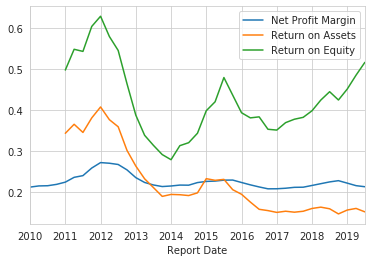

In [40]:
df_fin_signals.loc['AAPL'].plot()

### Financial Signals - Time Lag

Each financial report has two dates in the simfin database: Report Date and Publish Date. These are discussed in more detail in Tutorial 01. Briefly explained, the Report Date is written on the financial report e.g. 2012-12-31 means that the data is for the quarter or year ending on that date. But the data was typically not available to the public on that date.

The Publish Date is when that data was actually made available to the public, which is typically one or more months after the Report Date. But financial reports can also get revised sometimes years later. The simfin database always uses the latest data, so we could have a Report Date of 2012-12-31 and a Publish Date of e.g. 2015-05-01.

A simple solution which is often used in practice, is to use the Report Date with a time-lag of e.g. 1 month, so that a Report Date of 2012-12-31 becomes 2013-01-31. That way there is less risk of "cheating" by using data before it was publicly known. You can add an even greater time-lag of 2 or 3 months if you like.

Note that it is important to add the time-lag *before* the data is upsampled to daily data-points.

For example, we can use a helper-function from simfin to add a time-lag of 30 days to the financial signals we calculated above:

In [41]:
# Add time-lag of 30 days.
df_fin_signals2 = sf.add_date_offset(df=df_fin_signals,
                                     date_index=REPORT_DATE,
                                     offset=pd.DateOffset(days=30))

# Show the result.
df_fin_signals2

Net Profit Margin  Return on Assets  Return on Equity
Ticker Report Date                                                       
AAPL   2010-04-30            0.211490               NaN               NaN
       2010-07-30            0.214350               NaN               NaN
       2010-10-30            0.214841               NaN               NaN
       2011-01-30            0.218122               NaN               NaN
       2011-04-30            0.223577          0.342675          0.496899
...                               ...               ...               ...
MSFT   2018-10-30            0.163777          0.075549          0.209923
       2019-01-30            0.283144          0.131018          0.428037
       2019-04-30            0.285784          0.142267          0.440768
       2019-07-30            0.311817          0.151595          0.474383
       2019-10-30            0.316561          0.159515          0.478021

[117 rows x 3 columns]

### Financial Signals - Reindex

The financial signals we calculated above, only have data-points at quarterly intervals because we used TTM data. In order to use these signals in trading strategies we first need to reindex the DataFrame so it has data-points for all the same days as the share-price data. Resampling and reindexing is explained in greater detail in Tutorial 02.

It is very easy to reindex the financial signals using simfin's helper-function. We use `method='ffill'` which means that the newly generated data-points should be forward-filled with the last-known values. This is to avoid cheating (so-called "look-ahead-bias") by using data before it was actually known. But in some types of statistical analysis it might be useful to use e.g. linear interpolation instead, even though it is otherwise cheating.

In [42]:
# Reindex financial signals to the same days as share-price data.
df_fin_signals_daily = sf.reindex(df_src=df_fin_signals,
                                  df_target=df_prices,
                                  method='ffill')

# Show the result.
df_fin_signals_daily.dropna()

Net Profit Margin  Return on Assets  Return on Equity
Ticker Date                                                             
AAPL   2011-03-31           0.223577          0.342675          0.496899
       2011-04-01           0.223577          0.342675          0.496899
       2011-04-04           0.223577          0.342675          0.496899
       2011-04-05           0.223577          0.342675          0.496899
       2011-04-06           0.223577          0.342675          0.496899
...                              ...               ...               ...
MSFT   2019-11-11           0.316561          0.159515          0.478021
       2019-11-12           0.316561          0.159515          0.478021
       2019-11-13           0.316561          0.159515          0.478021
       2019-11-14           0.316561          0.159515          0.478021
       2019-11-15           0.316561          0.159515          0.478021

[6519 rows x 3 columns]

We can also plot the reindexed signals for the stock MSFT. Note the "staircase" patterns, which is because we are using forward-fill with the last-known values:

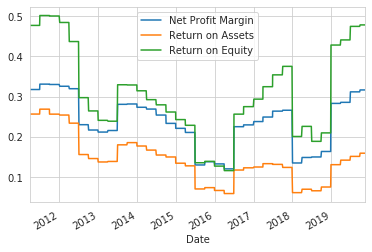

In [43]:
df_fin_signals_daily.loc['MSFT'].dropna().plot()

### Financial Signals - SimFin Function

The simfin package provides a function `sf.fin_signals` that calculates several financial signals such as Net Profit Margin, Debt Ratio, ROA, etc. More signals might get added in the future.

The function can be called in different ways. For example, if we do *not* supply the DataFrame with share-prices, the financial signals are *not* reindexed to daily data-points:

In [44]:
df_fin_signals = sf.fin_signals(df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm)

df_fin_signals.dropna().head()

Current Ratio  Debt Ratio  Gross Profit Margin  \
Ticker Report Date                                                   
AAPL   2013-09-30        1.678639    0.081932             0.376245   
       2014-06-30        1.470598    0.139493             0.383953   
       2014-09-30        1.080113    0.152239             0.385880   
       2014-12-31        1.133024    0.138999             0.392553   
       2015-03-31        1.156005    0.167963             0.396585   

                    Net Profit Margin  Return on Assets  Return on Equity  
Ticker Report Date                                                         
AAPL   2013-09-30            0.216705          0.210361          0.313315  
       2014-06-30            0.216426          0.192914          0.312556  
       2014-09-30            0.216144          0.190870          0.319792  
       2014-12-31            0.222533          0.197447          0.342849  
       2015-03-31            0.225335          0.232090          0.397807

If we *do* supply a DataFrame with share-prices, then the financial signals *are* reindexed to daily data-points using the index of the share-prices. We can also set a fill-method which is 'ffill' (forward-fill) by default, so the missing data-points are filled with the last-known values.

In [45]:
df_fin_signals = sf.fin_signals(df_prices=df_prices,
                                df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm,
                                fill_method='ffill')

df_fin_signals.dropna().head()

Current Ratio  Debt Ratio  Gross Profit Margin  \
Ticker Date                                                         
AAPL   2013-09-30       1.678639    0.081932             0.376245   
       2013-10-01       1.678639    0.081932             0.376245   
       2013-10-02       1.678639    0.081932             0.376245   
       2013-10-03       1.678639    0.081932             0.376245   
       2013-10-04       1.678639    0.081932             0.376245   

                   Net Profit Margin  Return on Assets  Return on Equity  
Ticker Date                                                               
AAPL   2013-09-30           0.216705          0.210361          0.313315  
       2013-10-01           0.216705          0.210361          0.313315  
       2013-10-02           0.216705          0.210361          0.313315  
       2013-10-03           0.216705          0.210361          0.313315  
       2013-10-04           0.216705          0.210361          0.313315

Because the daily signals are forward-filled, they show as a "staircase" patterns when plotted. For example, this shows the Return on Assets (ROA) for the stocks:

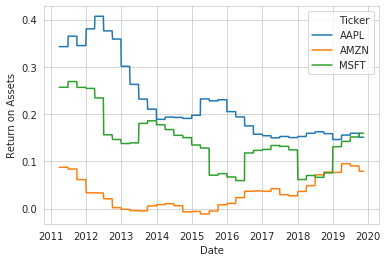

In [46]:
sns.lineplot(x=DATE, y=ROA, hue=TICKER,
             data=df_fin_signals.reset_index())

The function `sf.fin_signals` lets us apply another function to the signals before reindexing them to daily data-points, e.g. to get multi-year averages. For example, we may calculate the 2-year averages by passing the argument `func=sf.avg_ttm_2y`.

In [47]:
df_fin_signals_2y = sf.fin_signals(df_prices=df_prices,
                                   df_income_ttm=df_income_ttm,
                                   df_balance_ttm=df_balance_ttm,
                                   func=sf.avg_ttm_2y,
                                   fill_method='ffill')

df_fin_signals_2y.dropna().head()

Current Ratio  Debt Ratio  Gross Profit Margin  \
Ticker Date                                                         
AAPL   2014-09-30       1.379376    0.117086             0.381063   
       2014-10-01       1.379376    0.117086             0.381063   
       2014-10-02       1.379376    0.117086             0.381063   
       2014-10-03       1.379376    0.117086             0.381063   
       2014-10-06       1.379376    0.117086             0.381063   

                   Net Profit Margin  Return on Assets  Return on Equity  
Ticker Date                                                               
AAPL   2014-09-30           0.216424          0.200615          0.316554  
       2014-10-01           0.216424          0.200615          0.316554  
       2014-10-02           0.216424          0.200615          0.316554  
       2014-10-03           0.216424          0.200615          0.316554  
       2014-10-06           0.216424          0.200615          0.316554

When plotting the 2-year average Return on Assets (ROA), it is less volatile than the normal 1-year ROA plotted above. But these curves are also "staircases" because the daily data-points are still forward-filled with the last-known quarterly values.

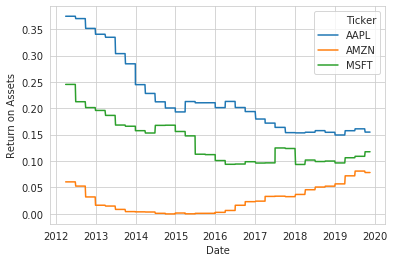

In [48]:
sns.lineplot(x=DATE, y=ROA, hue=TICKER,
             data=df_fin_signals_2y.reset_index())

## Growth Signals

Let us now calculate growth-rates from the Income Statements and use the growth-rates as signals. The simfin package has a function `sf.rel_change` which was already used to calculate growth-rates in Tutorial 03. We will use that function again here. For example, we may calculate the year-over-year growth-rates from TTM data as follows:

In [49]:
# Select the data-columns to calculate growth-rates for.
df = df_income_ttm[[REVENUE, NET_INCOME]]

# Dict mapping to the new column-names.
new_names = {REVENUE: SALES_GROWTH,
             NET_INCOME: EARNINGS_GROWTH}

# Calculate the growth-rates.
df_growth = sf.rel_change(df=df, freq='q', quarters=4,
                          future=False, annualized=False,
                          new_names=new_names)

# Show the result.
df_growth.head(8)

Sales Growth  Earnings Growth
Ticker Report Date                               
AAPL   2010-03-31            NaN              NaN
       2010-06-30            NaN              NaN
       2010-09-30            NaN              NaN
       2010-12-31            NaN              NaN
       2011-03-31       0.710600         0.808361
       2011-06-30       0.757291         0.929149
       2011-09-30       0.659624         0.849854
       2011-12-31       0.675878         0.982210

If we want daily data-points like the share-prices then we can reindex the DataFrame:

In [50]:
# Reindex the growth-rates to the same dates as the share-prices.
df_growth_daily = sf.reindex(df_src=df_growth,
                             df_target=df_prices, method='ffill')

# Show the result.
df_growth_daily.dropna().head()

Sales Growth  Earnings Growth
Ticker Date                                     
AAPL   2011-03-31        0.7106         0.808361
       2011-04-01        0.7106         0.808361
       2011-04-04        0.7106         0.808361
       2011-04-05        0.7106         0.808361
       2011-04-06        0.7106         0.808361

We can plot the growth-rates for ticker MSFT. Because the daily data-points were forward-filled with the last-known values, the lines in the plot appear as "staircases":

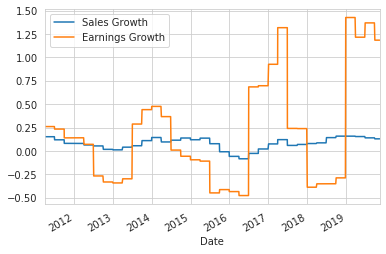

In [51]:
df_growth_daily.loc['MSFT'].dropna().plot()

### Growth Signals - SimFin Function

The simfin package provides a function `sf.growth_signals` that calculates several growth-signals such as Sales Growth, Earnings Growth, FCF Growth, etc. More growth-signals might get added in the future.

The function calculates three types of growth-rates for each of the Sales, Earnings and FCF. For the Sales Growth we have the following:

- `SALES_GROWTH` is Year-Over-Year TTM Growth and is calculated from the TTM (Trailing Twelve Months) data as follows:

$$
    Sales\ Growth_t = \frac{Revenue\ TTM_t}{Revenue\ TTM_{t-1\ Year}} - 1
$$

- `SALES_GROWTH_YOY` is Year-Over-Year Quarterly Growth and is calculated from the Quarterly data as follows:

$$
    Sales\ Growth\ YOY_t = \frac{Revenue\ Quarterly_t}{Revenue\ Quarterly_{t-1\ Year}} - 1
$$

- `SALES_GROWTH_QOQ` is Quarter-Over-Quarter Growth and is calculated from the Quarterly data as follows:

$$
    Sales\ Growth\ QOQ_t = \frac{Revenue\ Quarterly_t}{Revenue\ Quarterly_{t-1\ Quarter}} - 1
$$

The function can be called in different ways. For example, if we do not pass a DataFrame with share-prices, then the growth-signals only have quarterly data-points, because they are not reindexed to daily data-points:

In [52]:
df_growth_signals = \
    sf.growth_signals(df_income_ttm=df_income_ttm,
                      df_income_qrt=df_income_qrt,
                      df_cashflow_ttm=df_cashflow_ttm,
                      df_cashflow_qrt=df_cashflow_qrt)

df_growth_signals.dropna().head()

Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Report Date                                                              
AAPL   2011-03-31          0.808361            -0.002831             0.947625   
       2011-06-30          0.929149             0.220645             1.246542   
       2011-09-30          0.849854            -0.093733             0.537372   
       2011-12-31          0.982210             0.972520             1.175883   
       2012-03-31          0.975092            -0.110380             0.941206   

                    FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Report Date                                                             
AAPL   2011-03-31     0.916121       -0.346298        1.741745      0.710600   
       2011-06-30     1.042480        0.823836        1.430180      0.757291   
       2011-09-30     0.825725       -0.422630        0.202875      0.659624   
       2011-12-31     0.924632        1.752646        0.894830      0.675878   
       2012-03-31     0.929103       -0.226791        1.241237      0.627883   

                    Sales Growth QOQ  Sales Growth YOY  
Ticker Report Date                                      
AAPL   2011-03-31          -0.077559          0.827321  
       2011-06-30           0.158268          0.819809  
       2011-09-30          -0.010535          0.389667  
       2011-12-31           0.638946          0.732658  
       2012-03-31          -0.154253          0.588600

If we supply a DataFrame with share-prices, then the growth-signals are reindexed to daily data-points using the index of the share-prices. We can also set a fill-method which is 'ffill' (forward-fill) by default, so the missing data-points are filled with the last-known values.

In [53]:
df_growth_signals = \
    sf.growth_signals(df_prices=df_prices,
                      df_income_ttm=df_income_ttm,
                      df_income_qrt=df_income_qrt,
                      df_cashflow_ttm=df_cashflow_ttm,
                      df_cashflow_qrt=df_cashflow_qrt,
                      fill_method='ffill')

df_growth_signals.dropna().head()

Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Date                                                                    
AAPL   2011-03-31         0.808361            -0.002831             0.947625   
       2011-04-01         0.808361            -0.002831             0.947625   
       2011-04-04         0.808361            -0.002831             0.947625   
       2011-04-05         0.808361            -0.002831             0.947625   
       2011-04-06         0.808361            -0.002831             0.947625   

                   FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Date                                                                   
AAPL   2011-03-31    0.916121       -0.346298        1.741745        0.7106   
       2011-04-01    0.916121       -0.346298        1.741745        0.7106   
       2011-04-04    0.916121       -0.346298        1.741745        0.7106   
       2011-04-05    0.916121       -0.346298        1.741745        0.7106   
       2011-04-06    0.916121       -0.346298        1.741745        0.7106   

                   Sales Growth QOQ  Sales Growth YOY  
Ticker Date                                            
AAPL   2011-03-31         -0.077559          0.827321  
       2011-04-01         -0.077559          0.827321  
       2011-04-04         -0.077559          0.827321  
       2011-04-05         -0.077559          0.827321  
       2011-04-06         -0.077559          0.827321

Because the daily signals are forward-filled, they appear as a "staircase" when plotted. For example, this shows the Earnings Growth (TTM 1-year growth):

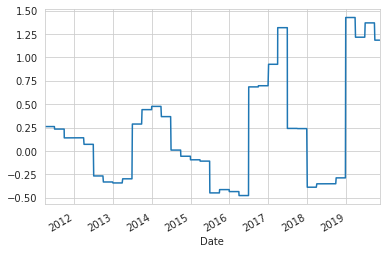

In [54]:
df_growth_signals.loc['MSFT', EARNINGS_GROWTH].dropna().plot()

The function `sf.growth_signals` lets us apply another function to the signals before reindexing them to daily data-points, e.g. to get multi-year averages. For example, we may use the 2-year averages by passing the argument `func=sf.avg_ttm_2y`. This may not make sense for all the growth-signals, e.g. in this case the 2-year average probably does not make sense on the Quarter-Over-Quarter (QOQ) growth-rates.

In [55]:
df_growth_signals_2y = \
    sf.growth_signals(df_prices=df_prices,
                      df_income_ttm=df_income_ttm,
                      df_income_qrt=df_income_qrt,
                      df_cashflow_ttm=df_cashflow_ttm,
                      df_cashflow_qrt=df_cashflow_qrt,
                      fill_method='ffill',
                      func=sf.avg_ttm_2y)

df_growth_signals_2y.dropna().head()

Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Date                                                                    
AAPL   2012-04-02         0.891727            -0.056606             0.944416   
       2012-04-03         0.891727            -0.056606             0.944416   
       2012-04-04         0.891727            -0.056606             0.944416   
       2012-04-05         0.891727            -0.056606             0.944416   
       2012-04-09         0.891727            -0.056606             0.944416   

                   FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Date                                                                   
AAPL   2012-04-02    0.922612       -0.286545        1.491491      0.669241   
       2012-04-03    0.922612       -0.286545        1.491491      0.669241   
       2012-04-04    0.922612       -0.286545        1.491491      0.669241   
       2012-04-05    0.922612       -0.286545        1.491491      0.669241   
       2012-04-09    0.922612       -0.286545        1.491491      0.669241   

                   Sales Growth QOQ  Sales Growth YOY  
Ticker Date                                            
AAPL   2012-04-02         -0.115906           0.70796  
       2012-04-03         -0.115906           0.70796  
       2012-04-04         -0.115906           0.70796  
       2012-04-05         -0.115906           0.70796  
       2012-04-09         -0.115906           0.70796

When plotting the 2-year average Earnings Growth, it is less volatile than the 1-year Earnings Growth. But these curves are also "staircases" because the daily data-points are still forward-filled with the last-known values.

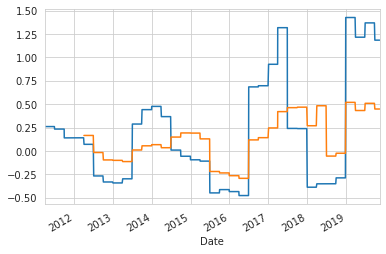

In [56]:
df_growth_signals.loc['MSFT', EARNINGS_GROWTH].dropna().plot()
df_growth_signals_2y.loc['MSFT', EARNINGS_GROWTH].dropna().plot()

## Valuation Signals

Let us now calculate signals such as P/E and P/Sales that relate the share-price to data from the financial reports such as Income Statements and Balance Sheets. These are also called *valuation ratios* because they measure how the shares are valued relative to e.g. the company's Earnings, Sales, Book-Value, etc.

### Per-Share Numbers

In order to calculate the valuation ratios, we first need to calculate per-share numbers from the financial reports, such as Earnings Per Share and Sales Per Share.

Each financial report in the SimFin database has two kinds of share-counts:

- `SHARES_BASIC` which is reported in the company's financial reports as "basic weighted-average number of shares".

- `SHARES_DILUTED` which is reported in the company's financial reports as "diluted weighted-average number of shares".

Both these share-counts are adjusted for stock-splits in the past, similarly to the share-prices so they are directly compatible. The basic and diluted share-counts are often very close and the difference is due to the potential dilution of stock-options. When calculating per-share numbers using financial data e.g. for use in valuation ratios, it is more conservative to use the diluted share-counts, so as to take potential future stock-dilution into account.

If a company has multiple classes of common stock, it gets a little complicated. The share-prices are *always* for the Class A stock, but the share-counts have been adjusted according to the conversion-ratios of the different stock-classes. This means that `SHARES_BASIC` and `SHARES_DILUTED` are Class-A *equivalent* so they are directly compatible with the share-prices for the Class-A stock.

For example, the company VISA has 3 classes of common stock but only the Class A stock trades on the stock-exchange under the ticker V. If we want to calculate the Earnings Per Share, so that we can calculate the P/E ratio, then we must take into account the other 2 classes of common stock, because the reported Net Income must be divided between all 3 classes of common stock according to certain ratios. If we did not make this adjustment, we would exaggerate the Net Income available to the Class A stock.

In the company's 'Consolidated Statements of Operations' (aka. Income Statement) from its [2018 Annual Report](https://www.sec.gov/cgi-bin/viewer?action=view&cik=1403161&accession_number=0001403161-18-000055&xbrl_type=v) for the 12-months ending on Sep. 30, 2018, we see that it had 'Basic weighted average shares outstanding' of 1792 Class A shares, 245 Class B shares, and 12 Class C shares (all in millions).  The conversion rate from [Class B](https://simfin.com/data/sclasses/618239) to Class A stock is 1.65, and from [Class C](https://simfin.com/data/sclasses/618242) to Class A stock is 4. So we convert the total number of Class A, B, and C shares into a single Class A *equivalent* share-count as follows:

$$
Class\ A\ Equivalent\ Shares = 1792 + 245 \cdot 1.65 + 12 \cdot 4 = 2244.25
$$

This is the number reported as `SHARES_BASIC` in the SimFin database for the 2018 annual Income Statement. A similar calculation is done for `SHARES_DILUTED`.

We can now use these share-counts to calculate e.g the Earnings Per *Class A equivalent* Share, so we can calculate a P/E ratio that correctly takes all 3 share-classes into account.

This sounds very complicated, but it is all handled by the SimFin database, so you generally do not have to worry about it, as long as you remember that the share-prices are *always* for Class A shares, and the share-counts are Class A *equivalent*.

Some companies have more stock-classes trading on the stock-exchange. For example, Berkshire Hathaway has both its Class A and B shares trading on the stock-exchange. Currently the SimFin database only supports the Class A shares, even though in this particular case, the Class A shares are actually very thinly traded as most people are trading the Class B shares.

### P/Sales Ratio

The P/Sales ratio is a valuation ratio defined as the daily share-price divided by the most recent Sales Per Share for the preceding year:

$$
    P/Sales_t = \frac{Share\ Price_t}{Sales\ Per\ Share_t}
$$

First we need to calculate the Sales Per Share. We use TTM data to get 4 data-points per year, each covering the preceding 12 months.

In [57]:
df_sales_per_share = df_income_ttm[REVENUE].div(df_income_ttm[SHARES_DILUTED], axis=0)
df_sales_per_share

Ticker  Report Date
AAPL    2010-03-31      7.968248
        2010-06-30      8.854177
        2010-09-30     10.076496
        2010-12-31     11.742380
        2011-03-31     13.414276
                         ...    
MSFT    2018-09-30     14.758501
        2018-12-31     15.186565
        2019-03-31     15.692723
        2019-06-30     16.231523
        2019-09-30     16.774002
Length: 117, dtype: float64

The above data only has 4 data-points per year, so we need to reindex it using the DataFrame with share-prices, to get daily data-points. We do this by forward-filling with the last-known data-points:

In [58]:
df_sps_daily = sf.reindex(df_src=df_sales_per_share,
                          df_target=df_prices, method='ffill')

df_sps_daily.dropna()

Ticker  Date      
AAPL    2010-03-31     7.968248
        2010-04-01     7.968248
        2010-04-05     7.968248
        2010-04-06     7.968248
        2010-04-07     7.968248
                        ...    
MSFT    2019-11-11    16.774002
        2019-11-12    16.774002
        2019-11-13    16.774002
        2019-11-14    16.774002
        2019-11-15    16.774002
Length: 7278, dtype: float64

We then calculate the P/Sales ratio from the share-price and the daily Sales Per Share:

In [59]:
# Calculate P/Sales ratio.
df_psales = df_prices[CLOSE].div(df_sps_daily, axis=0)

# Rename the data-column.
df_psales.rename(PSALES, inplace=True)

# Show the result.
df_psales.dropna()

Ticker  Date      
AAPL    2010-03-31    4.213147
        2010-04-01    4.230541
        2010-04-05    4.275720
        2010-04-06    4.294545
        2010-04-07    4.313545
                        ...   
MSFT    2019-11-11    8.710503
        2019-11-12    8.767735
        2019-11-13    8.782043
        2019-11-14    8.826755
        2019-11-15    8.940621
Name: P/Sales, Length: 7278, dtype: float64

We can also plot the P/Sales ratios:

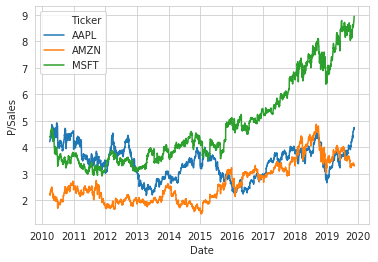

In [60]:
sns.lineplot(x=DATE, y=PSALES, hue=TICKER,
             data=df_psales.reset_index())

### P/E Ratio

The P/E ratio is a valuation ratio defined as:

$$
    P/E_t = \frac{Share\ Price_t}{Earnings\ Per\ Share_t}
$$

Earnings are also called Net Income and the SimFin database has two data-columns for this: `NET_INCOME` and `NET_INCOME_COMMON`. Which one should we use in the P/E calculation?

The difference is that `NET_INCOME` is for the earnings that are available to both common and preferred shareholders, while `NET_INCOME_COMMON` is only the part of the earnings that are available to common shareholders. Because the share-prices in the SimFin database are always for the first class of common stock, we need to use `NET_INCOME_COMMON` when calculating the P/E ratio.

However, for about 93% of all the Income Statements in the SimFin Database, the value of `NET_INCOME` is exactly the same as `NET_INCOME_COMMON`. For another 6% of the Income Statements, the difference between `NET_INCOME` and `NET_INCOME_COMMON` is less than 25%. Typically these differences are for smaller and less-known companies. For companies with revenue of USD 1 billion or more, it is only 1% of the Income Statements where the difference between `NET_INCOME` and `NET_INCOME_COMMON` is more than 10%.

Indeed, for the 3 companies we are considering here, these numbers are identical:

In [61]:
(df_income_ttm[NET_INCOME] - df_income_ttm[NET_INCOME_COMMON]).describe()

count    117.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

So in order to calculate the P/E ratio, we first need to calculate the Earnings Per Share:

In [62]:
df_earnings_per_share = df_income_ttm[NET_INCOME_COMMON].div(df_income_ttm[SHARES_DILUTED], axis=0)
df_earnings_per_share

Ticker  Report Date
AAPL    2010-03-31     1.685204
        2010-06-30     1.897889
        2010-09-30     2.164844
        2010-12-31     2.561271
        2011-03-31     2.999119
                         ...   
MSFT    2018-09-30     2.417108
        2018-12-31     4.299990
        2019-03-31     4.484736
        2019-06-30     5.061267
        2019-09-30     5.309988
Length: 117, dtype: float64

The above data only has 4 data-points per year, so we need to reindex it using the DataFrame with share-prices, to get daily data-points. We do this by forward-filling with the last-known data-points:

In [63]:
df_eps_daily = sf.reindex(df_src=df_earnings_per_share,
                          df_target=df_prices, method='ffill')

df_eps_daily.dropna()

Ticker  Date      
AAPL    2010-03-31    1.685204
        2010-04-01    1.685204
        2010-04-05    1.685204
        2010-04-06    1.685204
        2010-04-07    1.685204
                        ...   
MSFT    2019-11-11    5.309988
        2019-11-12    5.309988
        2019-11-13    5.309988
        2019-11-14    5.309988
        2019-11-15    5.309988
Length: 7278, dtype: float64

We then calculate the P/E ratio from the share-price and the daily Earnings Per Share:

In [64]:
# Calculate the P/E ratio.
df_pe = df_prices[CLOSE] / df_eps_daily

# Rename the data-column.
df_pe.rename(PE, inplace=True)

# Show the result.
df_pe.dropna()

Ticker  Date      
AAPL    2010-03-31    19.921265
        2010-04-01    20.003510
        2010-04-05    20.217134
        2010-04-06    20.306144
        2010-04-07    20.395985
                        ...    
MSFT    2019-11-11    27.516068
        2019-11-12    27.696859
        2019-11-13    27.742057
        2019-11-14    27.883300
        2019-11-15    28.243000
Name: P/E, Length: 7278, dtype: float64

Let us first plot the P/E ratio for ticker AMZN. Because it has had negative and near-zero earnings, it results in both negative and extremely large P/E ratios.

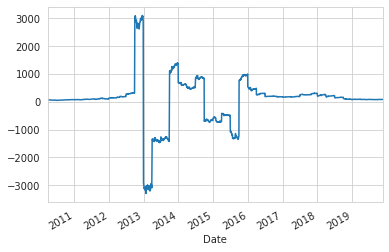

In [65]:
df_pe.loc['AMZN'].dropna().plot()

We can then plot the P/E ratios for the other two stocks:

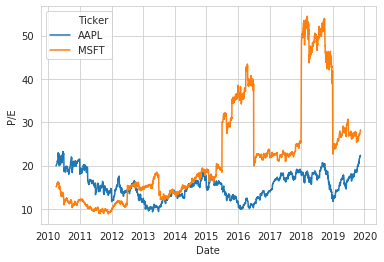

In [66]:
sns.lineplot(x=DATE, y=PE, hue=TICKER,
             data=df_pe.loc[['AAPL', 'MSFT']].reset_index())

The large spikes in the P/E ratios for MSFT are probably due to large drops in Net Income, as shown in the following plot, which caused the P/E ratio to greatly increase.

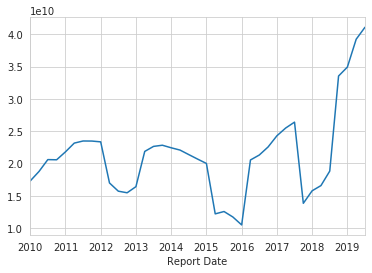

In [67]:
df_income_ttm.loc['MSFT', NET_INCOME_COMMON].plot()

### P/FCF Ratio

One of the problems with Net Income is that it includes non-cash and non-recurring items such as Goodwill Impairments, and these can sometimes be the biggest part of the Net Income. Furthermore, when a company invests in new assets, the cash payments are made immediately, but they are subtracted over a number of years from the Net Income, which is called Depreciation and Amortization.

In order to get a more cash-based measure of earnings, we must estimate the recurring cash-flows from operations, and subtract the cash used for investing in new factories, equipment and other assets. This is called Free Cash Flow (FCF).

There are many different ways of calculating FCF depending on exactly what you want to measure, and from which perspective e.g. whether you are a lender or investor. Let us use a simple formula here, which takes the Net Cash from Operations (`NET_CASH_OPS`) and subtracts the Capital Expenditures (`CAPEX`) used to buy new productive assets. A few things should be noted:

The `NET_CASH_OPS` is basically the company's Net Income with adjustments for non-cash items and changes in working-capital. Some of these items may be non-recurring, so it is not a perfect estimate of the recurring cashflow from operations.

The `CAPEX` is actually a data-column named "Change in Fixed Assets & Intangibles", following the Bloomberg naming standard. It is calculated from two items on the Cash-Flow Statement: "Disposition of Fixed Assets & Intangibles" minus "Acquisition of Fixed Assets & Intangibles". These are available as separate data-columns `DISP_FIX_ASSETS_INT` and `ACQ_FIX_ASSETS_INT` in the SimFin Premium dataset (which requires a paid subscription). But companies often do not report these separately in the Cash-Flow Statement. Many companies only report the combination as `CHG_FIX_ASSETS_INT`, which we have therefore given the alias `CAPEX` for easy reference.

This is the data we will use to calculate FCF:

In [68]:
df_cashflow_ttm[NET_CASH_OPS].head()

Ticker  Report Date
AAPL    2010-03-31     1.349100e+10
        2010-06-30     1.602200e+10
        2010-09-30     1.859500e+10
        2010-12-31     2.258700e+10
        2011-03-31     2.647600e+10
Name: Net Cash from Operating Activities, dtype: float64

In [69]:
df_cashflow_ttm[CAPEX].head()

Ticker  Report Date
AAPL    2010-03-31    -1.426000e+09
        2010-06-30    -1.780000e+09
        2010-09-30    -2.121000e+09
        2010-12-31    -3.003000e+09
        2011-03-31    -3.358000e+09
Name: Change in Fixed Assets & Intangibles, dtype: float64

Because `CAPEX` is defined as the Disposition *minus* Acquisition of Fixed Assets and Intangibles, we have to add `CAPEX` to `NET_CASH_OPS` in order to calculate FCF:

`FCF` = `NET_CASH_OPS` + (`DISP_FIX_ASSETS_INT` - `ACQ_FIX_ASSETS_INT`) = `NET_CASH_OPS` + `CAPEX`

which is done as follows using the Cash-Flow data:

In [70]:
# Calculate Free Cash Flow.
df_fcf_ttm = df_cashflow_ttm[NET_CASH_OPS] + df_cashflow_ttm[CAPEX]

# Rename the data-column.
df_fcf_ttm.rename(FCF, inplace=True)

Ticker  Report Date
AAPL    2010-03-31     1.206500e+10
        2010-06-30     1.424200e+10
        2010-09-30     1.647400e+10
        2010-12-31     1.958400e+10
        2011-03-31     2.311800e+10
                           ...     
MSFT    2018-09-30     3.199900e+10
        2018-12-31     3.190300e+10
        2019-03-31     3.364100e+10
        2019-06-30     3.826000e+10
        2019-09-30     3.863800e+10
Name: Free Cash Flow, Length: 117, dtype: float64

We can then plot and compare the FCF and Net Income. For example, for the ticker MSFT, the FCF is more stable and does not have the big drops in Net Income, which were perhaps due to non-cash deductions.

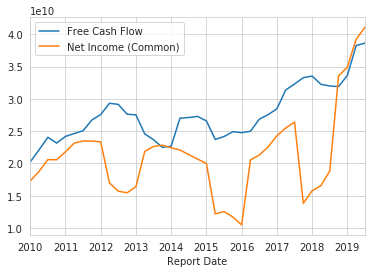

In [71]:
ticker = 'MSFT'

# Combine both time-series into a single DataFrame so the
# legend is shown properly when plotting it.
df = pd.concat([df_fcf_ttm.loc[ticker],
                df_income_ttm.loc[ticker, NET_INCOME_COMMON]], axis=1)

df.plot()

We can then calculate the per-share FCF:

In [72]:
df_fcf_per_share = df_fcf_ttm.div(df_income_ttm[SHARES_DILUTED])
df_fcf_per_share

Ticker  Report Date
AAPL    2010-03-31     1.880502
        2010-06-30     2.208853
        2010-09-30     2.545040
        2010-12-31     3.014600
        2011-03-31     3.546114
                         ...   
MSFT    2018-09-30     4.109944
        2018-12-31     4.089997
        2019-03-31     4.319733
        2019-06-30     4.934864
        2019-09-30     4.992635
Length: 117, dtype: float64

We can then reindex the FCF Per Share using the DataFrame with share-prices to get daily data-points:

In [73]:
df_fcf_daily = sf.reindex(df_src=df_fcf_per_share,
                          df_target=df_prices, method='ffill')

df_fcf_daily.dropna()

Ticker  Date      
AAPL    2010-03-31    1.880502
        2010-04-01    1.880502
        2010-04-05    1.880502
        2010-04-06    1.880502
        2010-04-07    1.880502
                        ...   
MSFT    2019-11-11    4.992635
        2019-11-12    4.992635
        2019-11-13    4.992635
        2019-11-14    4.992635
        2019-11-15    4.992635
Length: 7278, dtype: float64

Finally we may calculate the P/FCF ratio:

In [74]:
# Calculate the P/FCF ratio.
df_pfcf = df_prices[CLOSE] / df_fcf_daily

# Rename the data-column.
df_pfcf.rename(PFCF, inplace=True)

# Show the result.
df_pfcf.dropna()

Ticker  Date      
AAPL    2010-03-31    17.852359
        2010-04-01    17.926063
        2010-04-05    18.117501
        2010-04-06    18.197267
        2010-04-07    18.277778
                        ...    
MSFT    2019-11-11    29.265109
        2019-11-12    29.457392
        2019-11-13    29.505463
        2019-11-14    29.655685
        2019-11-15    30.038248
Name: P/FCF, Length: 7278, dtype: float64

If we print the P/FCF ratio for ticker AMZN, it still contains some extreme values, because the FCF has sometimes been nearly zero.

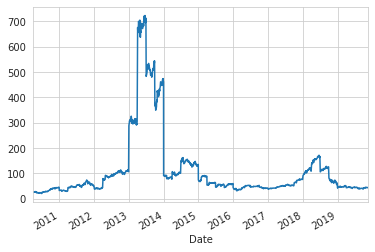

In [75]:
df_pfcf.loc['AMZN'].dropna().plot()

We can also plot the P/FCF ratios for tickers AAPL and MSFT, which are more stable:

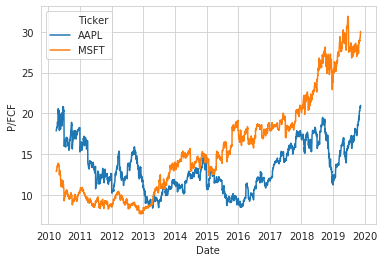

In [76]:
sns.lineplot(x=DATE, y=PFCF, hue=TICKER,
             data=df_pfcf.loc[['AAPL', 'MSFT']].reset_index())

### P/E Ratio (2-Year Average Earnings)

We saw above how the P/E ratio could be very volatile e.g. if the company has a temporary drop in earnings, and if it has losses then it causes the P/E ratio to become negative, and earnings close to zero causes the P/E ratio to explode.

One solution is to use the average earnings for the last few years. Pandas has a built-in function called `rolling` which is normally used for calculating moving averages. But we should not use it here, because we are using TTM-data which has 4 data-points per year, each covering the preceding 12-month period, so we would overweigh the most recent quarterly earnings if we were to use `rolling`. Instead we calculate the average between the current TTM data-point, and the data-point 4 quarters in the past. This gives us the average of the 2 last years of earnings.

This is the helper-function for calculating it, which assumes 4 TTM data-points per year:

In [77]:
avg_ttm_2y = lambda df: 0.5 * (df + df.shift(4))

Because we use two data-rows in this calculation, we **MUST** use Pandas' `groupby` functionality when the DataFrame contains data for multiple stocks, otherwise the grouping is not preserved, and the calculations of 2-year averages may use data from two different stocks. We can use simfin's helper-function `apply` for this:

In [78]:
df_earnings_2y = sf.apply(df=df_income_ttm[NET_INCOME_COMMON],
                          func=avg_ttm_2y)

df_earnings_2y

Ticker  Report Date
AAPL    2010-03-31              NaN
        2010-06-30              NaN
        2010-09-30              NaN
        2010-12-31              NaN
        2011-03-31     1.518200e+10
                           ...     
MSFT    2018-09-30     2.260850e+10
        2018-12-31     2.368500e+10
        2019-03-31     2.534650e+10
        2019-06-30     2.790550e+10
        2019-09-30     2.995650e+10
Name: Net Income (Common), Length: 117, dtype: float64

We can then use this 2-year average to calculate the Earnings Per Share:

In [79]:
df_eps_2y = df_earnings_2y.div(df_income_ttm[SHARES_DILUTED])
df_eps_2y.dropna()

Ticker  Report Date
AAPL    2011-03-31     2.328796
        2011-06-30     2.741400
        2011-09-30     3.045444
        2011-12-31     3.775615
        2012-03-31     4.415502
                         ...   
MSFT    2018-09-30     2.903831
        2018-12-31     3.036441
        2019-03-31     3.254663
        2019-06-30     3.599316
        2019-09-30     3.870849
Length: 105, dtype: float64

We can then reindex using the share-price DataFrame so as to get daily data-points:

In [80]:
df_eps_2y_daily = sf.reindex(df_src=df_eps_2y,
                             df_target=df_prices, method='ffill')

df_eps_2y_daily.dropna()

Ticker  Date      
AAPL    2011-03-31    2.328796
        2011-04-01    2.328796
        2011-04-04    2.328796
        2011-04-05    2.328796
        2011-04-06    2.328796
                        ...   
MSFT    2019-11-11    3.870849
        2019-11-12    3.870849
        2019-11-13    3.870849
        2019-11-14    3.870849
        2019-11-15    3.870849
Length: 6519, dtype: float64

Finally we can calculate the P/E ratios using the 2-year earnings average:

In [81]:
# Calculate the P/E ratios using 2-year earnings average.
df_pe_2y = df_prices[CLOSE].div(df_eps_2y_daily, axis=0)

# Rename the data-column.
PE_2Y = 'P/E (2Y Avg. Earnings)'
df_pe_2y.rename(PE_2Y, inplace=True)

# Show the result.
df_pe_2y.dropna()

Ticker  Date      
AAPL    2011-03-31    21.378730
        2011-04-01    21.136631
        2011-04-04    20.929872
        2011-04-05    20.788812
        2011-04-06    20.736639
                        ...    
MSFT    2019-11-11    37.746242
        2019-11-12    37.994249
        2019-11-13    38.056251
        2019-11-14    38.250007
        2019-11-15    38.743439
Name: P/E (2Y Avg. Earnings), Length: 6519, dtype: float64

We can then plot the result for ticker AMZN, which still has extreme values because 2-year earnings average was not enough to smoothen out the years of negative earnings:

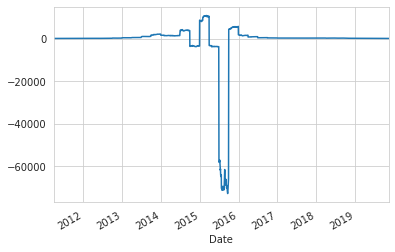

In [82]:
df_pe_2y.loc['AMZN'].dropna().plot()

If we plot for tickers AAPL and MSFT, we see that especially MSFT has improved, because it does not have the huge jumps we saw above, when using only 1 year of TTM earnings:

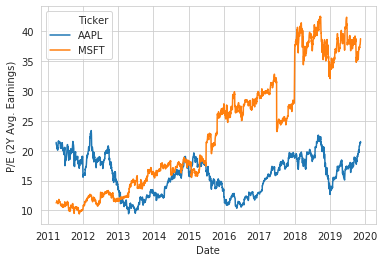

In [83]:
sns.lineplot(x=DATE, y=PE_2Y, hue=TICKER,
             data=df_pe_2y.loc[['AAPL', 'MSFT']].reset_index())

### Valuation Signals - Helper-Function

If you want to create several valuation signals, then it is useful to create a small helper-function. The use of Pandas `groupby` is not necessary because all the formulas only use a single row of data, so the function can take DataFrames with one or more stocks.

In [84]:
def val_signals(df_prices, df_income_ttm, df_cashflow_ttm,
                shares_index=SHARES_DILUTED):
    """
    Calculate valuation signals for all stocks in the DataFrames.
    
    :param df_prices:
        Pandas DataFrame with share-prices for multiple stocks.
        
    :param df_income_ttm:
        Pandas DataFrame with Income Statement TTM data for
        multiple stocks.
    
    :param df_cashflow_ttm:
        Pandas DataFrame with Cash-Flow Statement TTM data for
        multiple stocks.

    :param shares_index:
        String with the data-column name for the share-count
        e.g. SHARES_DILUTED or SHARES_BASIC.
    
    :return:
        Pandas DataFrame with valuation signals.
    """

    # Create a DataFrame with the financial data we need.
    # Start by copying data from the Income Statements.
    df = df_income_ttm[[REVENUE, NET_INCOME_COMMON]].copy()

    # Calculate FCF and add it as a new column to the DataFrame.
    df[FCF] = df_cashflow_ttm[NET_CASH_OPS] + df_cashflow_ttm[CAPEX]

    # Calculate Per-Share numbers.
    df_per_share = df.div(df_income_ttm[shares_index], axis=0)
    
    # Reindex the per-share financial data to daily data-points.
    df_daily = sf.reindex(df_src=df_per_share,
                          df_target=df_prices,
                          method='ffill')
    
    # Create new DataFrame for the signals.
    df_signals = pd.DataFrame()
    
    # Use the closing share-price for all these signals.
    df_price = df_prices[CLOSE]
    
    # P/Sales ratio.
    df_signals[PSALES] = df_price / df_daily[REVENUE]
    
    # P/E ratio.
    df_signals[PE] = df_price / df_daily[NET_INCOME_COMMON]

    # P/FCF ratio.
    df_signals[PFCF] = df_price / df_daily[FCF]

    return df_signals

We can then calculate the valuation signals for multiple stocks:

In [85]:
df_val_signals = val_signals(df_prices=df_prices,
                             df_income_ttm=df_income_ttm,
                             df_cashflow_ttm=df_cashflow_ttm,
                             shares_index=SHARES_DILUTED)

df_val_signals.dropna()

P/Sales        P/E      P/FCF
Ticker Date                                      
AAPL   2010-03-31  4.213147  19.921265  17.852359
       2010-04-01  4.230541  20.003510  17.926063
       2010-04-05  4.275720  20.217134  18.117501
       2010-04-06  4.294545  20.306144  18.197267
       2010-04-07  4.313545  20.395985  18.277778
...                     ...        ...        ...
MSFT   2019-11-11  8.710503  27.516068  29.265109
       2019-11-12  8.767735  27.696859  29.457392
       2019-11-13  8.782043  27.742057  29.505463
       2019-11-14  8.826755  27.883300  29.655685
       2019-11-15  8.940621  28.243000  30.038248

[7278 rows x 3 columns]

We can then plot e.g. the P/E and P/FCF ratios for the ticker AMZN:

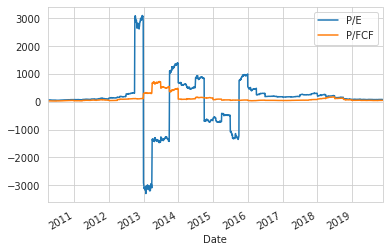

In [86]:
df_val_signals.loc['AMZN', [PE, PFCF]].dropna().plot()

We can also plot the P/FCF for the other two tickers AAPL and MSFT:

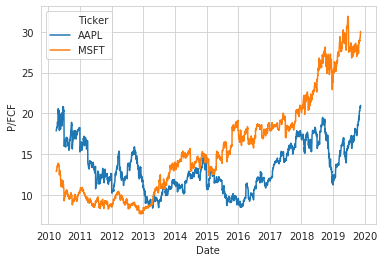

In [87]:
sns.lineplot(x=DATE, y=PFCF, hue=TICKER,
             data=df_val_signals.loc[['AAPL', 'MSFT']].reset_index())

### Valuation Signals - SimFin Function

The simfin package provides a function `sf.val_signals` that calculates several basic valuation signals such as P/E, P/Sales, etc. More signals might get added in the future.

In [88]:
df_val_signals = sf.val_signals(df_prices=df_prices,
                                df_income_ttm=df_income_ttm,
                                df_balance_ttm=df_balance_ttm,
                                df_cashflow_ttm=df_cashflow_ttm)

In [89]:
df_val_signals.dropna().head()

Dividend Yield    P/Book        P/E      P/FCF   P/Sales
Ticker Date                                                                
AAPL   2012-10-01        0.003991  5.273307  14.936804  15.037334  3.982912
       2012-10-02        0.003980  5.288663  14.980299  15.081121  3.994510
       2012-10-03        0.003920  5.369751  15.209983  15.312352  4.055756
       2012-10-04        0.003947  5.332563  15.104647  15.206307  4.027668
       2012-10-05        0.004033  5.218922  14.782756  14.882249  3.941835

We can plot e.g. the P/Book ratios for all the stocks:

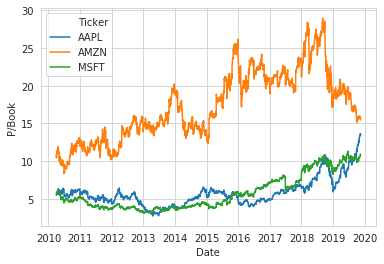

In [90]:
data = df_val_signals.reset_index()
sns.lineplot(x=DATE, y=PBOOK, hue=TICKER, data=data)

The function `sf.val_signals` lets us apply another function to the financial data before calculating the valuation ratios, e.g. to get multi-year averages of the Net Income and Revenue before calculating the P/E and P/Sales ratios. For example, we may use the 3-year averages by passing the argument `func=sf.avg_ttm_3y`.

In [91]:
df_val_signals_3y = sf.val_signals(df_prices=df_prices,
                                   df_income_ttm=df_income_ttm,
                                   df_balance_ttm=df_balance_ttm,
                                   df_cashflow_ttm=df_cashflow_ttm,
                                   func=sf.avg_ttm_3y)

We can then plot the P/FCF ratio which has been calculated using the 3-year average FCF. We only do this for tickers AAPL and MSFT because AMZN has extreme values.

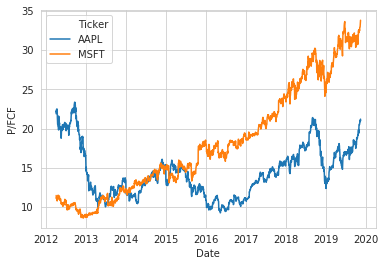

In [92]:
data = df_val_signals_3y.loc[['AAPL', 'MSFT']].reset_index()
sns.lineplot(x=DATE, y=PFCF, hue=TICKER, data=data)

## Limiting Extreme Values

Some of the valuation signals had extreme values, such as the P/E ratio because the Earnings can be negative or nearly zero. The simfin package provides a few functions for limiting extreme values and removing outliers.

First consider the statistics for the valuation signals and note how P/FCF and especially P/E has some extreme outliers.

In [93]:
df_val_signals.describe()

,Dividend Yield,P/Book,P/E,P/FCF,P/Sales
count,4220.000000,7278.000000,7278.000000,7278.000000,7278.000000
mean,0.019770,9.625969,31.364270,46.733056,3.642291
std,0.004941,6.293892,495.116544,91.693616,1.403264
min,0.003920,2.729737,-3298.653077,7.697018,1.489762
25%,0.015685,4.770853,13.650513,12.157100,2.717991
50%,0.020083,6.520711,18.253847,17.260142,3.487519
75%,0.023784,13.793645,67.068178,44.859153,4.048815
max,0.030984,28.965180,3091.064103,722.308475,8.940621


Let us say we want to limit the P/E ratio between 5 and 1000. Typically you would have a much lower bound than 1000, but this is chosen so we can see the limiting effect in the plot below. Let us further say we want P/FCF to be limited between 6 and 60. The other valuation signals will be left as-is. We create two dicts with the lower and upper bounds for P/E and P/FCF:

In [94]:
lower = {PE: 5, PFCF: 6}
upper = {PE: 1000, PFCF: 60}

The Pandas `clip` function (v.0.25) has poor support for clipping of only some columns, as it will set all other columns to NaN-values. So the simfin package provides a function `sf.clip` that allows us to limit only some of the columns, while keeping the original values in the remaining columns:

In [95]:
df_clipped = sf.clip(df=df_val_signals, lower=lower, upper=upper)

We can then plot the original and clipped P/E ratios for ticker AMZN to see the effect:

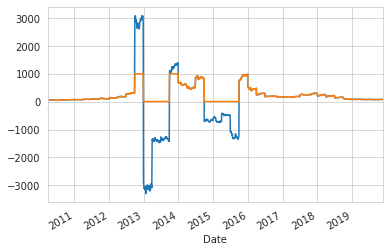

In [96]:
df_val_signals.loc['AMZN', PE].dropna().plot()
df_clipped.loc['AMZN', PE].dropna().plot()

We can also see from the statistics, that the P/E and P/FCF signals have been clipped between the specified bounds, while the other columns remain unchanged:

In [97]:
df_clipped.describe()

,Dividend Yield,P/Book,P/E,P/FCF,P/Sales
count,4220.000000,7278.000000,7278.000000,7278.000000,7278.000000
mean,0.019770,9.625969,90.210673,27.012222,3.642291
std,0.004941,6.293892,189.804843,18.889019,1.403264
min,0.003920,2.729737,5.000000,7.697018,1.489762
25%,0.015685,4.770853,13.650513,12.157100,2.717991
50%,0.020083,6.520711,18.253847,17.260142,3.487519
75%,0.023784,13.793645,67.068178,44.859153,4.048815
max,0.030984,28.965180,1000.000000,60.000000,8.940621


If we do not want to explicitly specify the bounds, but instead use the distribution of the data itself, we can take e.g. the 0.05 and 0.95 quantiles, and use those as the lower and upper boundaries when clipping. This is called *winsorizing* the data:

In [98]:
df_winsorized = sf.winsorize(df=df_val_signals, quantile=0.05)

Plotting the original and clipped P/E ratios for ticker AMZN, we can see the effect of this:

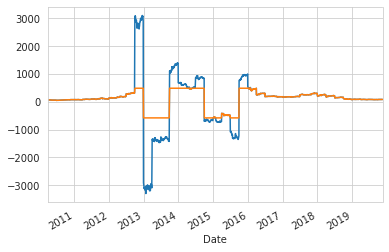

In [99]:
df_val_signals.loc['AMZN', PE].dropna().plot()
df_winsorized.loc['AMZN', PE].dropna().plot()

We can also print the statistics for the winsorized data that you may compare to the statistics for the original data shown above. Note that all columns have been winsorized.

In [100]:
df_winsorized.describe()

,Dividend Yield,P/Book,P/E,P/FCF,P/Sales
count,4220.000000,7278.000000,7278.000000,7278.000000,7278.000000
mean,0.019842,9.525991,38.305431,34.902069,3.609777
std,0.004480,6.006832,194.713377,36.664637,1.281148
min,0.012668,3.597921,-583.415900,8.975759,1.909904
25%,0.015685,4.770853,13.650513,12.157100,2.717991
50%,0.020083,6.520711,18.253847,17.260142,3.487519
75%,0.023784,13.793645,67.068178,44.859153,4.048815
max,0.027137,22.406629,481.301904,143.855543,7.057316


If we only want to winsorize some columns, we can pass a list of of strings with the column-names to the winsorize function:

In [101]:
df_winsorized2 = sf.winsorize(df=df_val_signals, quantile=0.05,
                              columns=[PE, PFCF])

If you compare the statistics for the winsorized data to the original data, you will see that only the specified columns have been winsorized:

In [102]:
df_winsorized2.describe()

,Dividend Yield,P/Book,P/E,P/FCF,P/Sales
count,4220.000000,7278.000000,7278.000000,7278.000000,7278.000000
mean,0.019770,9.625969,38.305431,34.902069,3.642291
std,0.004941,6.293892,194.713377,36.664637,1.403264
min,0.003920,2.729737,-583.415900,8.975759,1.489762
25%,0.015685,4.770853,13.650513,12.157100,2.717991
50%,0.020083,6.520711,18.253847,17.260142,3.487519
75%,0.023784,13.793645,67.068178,44.859153,4.048815
max,0.030984,28.965180,481.301904,143.855543,8.940621


## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
